In [1]:
import warnings
warnings.filterwarnings('ignore')

# 문제 상황

시나리오: 심각한 사고로 인하여 배가 침몰한 타이타닉 호에서 살아남은 사람들의 생존율에 관하여 분석하고자 한다

# 데이터 살펴보기

In [2]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
print('중복된 항목 수 :', len(df[df.duplicated()]))

중복된 항목 수 : 0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df.select_dtypes(exclude = 'object').columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [9]:
df.select_dtypes('object').columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

# 문제해결 프로세스 정의

## 문제 정의

사고로 침몰한 타이타닉호의 생존자들을 분석해보니 특정 분포를 가진다는 것을 알게 되었다.

생존자들을 분석하여 높은 생존율의 원일을 분석하여야 한다

## 기대효과

배가 침몰사고를 겪을 시 어떤 조건이 생존하는데 도움이 되는지 원인을 파악할 수 있다. 

또한, 생존율이 낮은 조건을 분석하여 배를 개선하고 사고가 나더라도 승객들의 생존율을 올릴 수 있을 것으로 예상된다

## 성과측정

시뮬레이션을 통한 생존율 분석

## 해결방안

Random Forest를 통한 생존자 분류

Session 1
- Data Loading(Transformation)
- Data EDA

Session 2
- Data Preprocessing

Session 3
- Modeling(general modeling, modeling with mlflow)
- RandomForestClassifier


# Session1 - Data Loading & EDA

In [4]:
import numpy as np
import pandas as pd
import re
import pickle
import joblib
import os

import mlflow

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import shap

import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#몇몇 columns들은 numeric 이 아닌 categorical 로 판단됨
num_to_cat = ['PassengerId', 'Pclass']
for i in num_to_cat:
    df[i] = df[i].astype(object)

In [7]:
cat_col = list(df.select_dtypes(object).columns)
num_col = list(df.select_dtypes(exclude = object).columns)
print(cat_col)
print(num_col)

['PassengerId', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
['Survived', 'Age', 'SibSp', 'Parch', 'Fare']


In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
#필요없는 columns 제거
df[cat_col].nunique().sort_values(ascending = False)

PassengerId    891
Name           891
Ticket         681
Cabin          147
Pclass           3
Embarked         3
Sex              2
dtype: int64

In [10]:
drop_col = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df.drop(drop_col, axis = 1, inplace = True)
for i in drop_col:
    cat_col.remove(i)

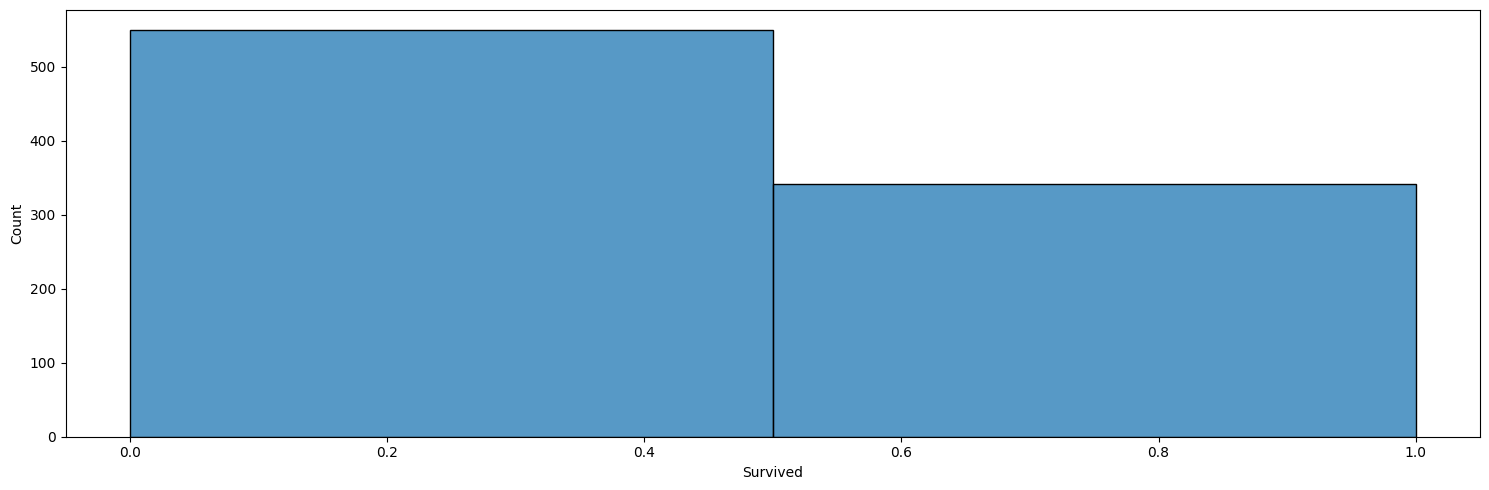

In [11]:
plt.figure(figsize = (15, 5))
sns.histplot(df['Survived'], bins =  2)
plt.tight_layout()
plt.show()

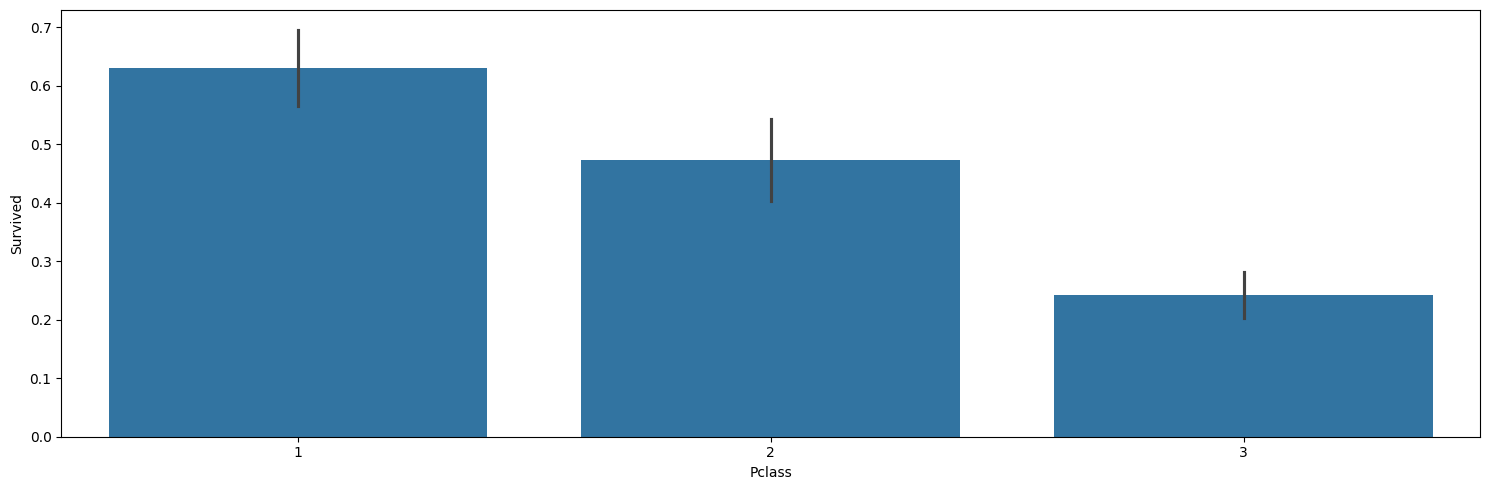

In [12]:
plt.figure(figsize = (15, 5))
sns.barplot(x = 'Pclass', y = 'Survived', data = df)
plt.tight_layout()
plt.show()

In [13]:
y = df['Survived']
X = df.drop('Survived', axis = 1, inplace = True)
num_col.remove('Survived')

# Session 2 - Data Preprocessing

In [14]:
#결측치 처리
df.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [15]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Embarked'] = df['Embarked'] = df['Embarked'].fillna('N')

In [16]:
df.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [17]:
#scaling
scaler = MinMaxScaler()
df[num_col] = scaler.fit_transform(df[num_col])
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,0.271174,0.125,0.0,0.014151,S
1,1,female,0.472229,0.125,0.0,0.139136,C
2,3,female,0.321438,0.000,0.0,0.015469,S
3,1,female,0.434531,0.125,0.0,0.103644,S
4,3,male,0.434531,0.000,0.0,0.015713,S


In [18]:
#get_dummies로 label encoding
df = pd.get_dummies(df)
df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_N,Embarked_Q,Embarked_S
0,0.271174,0.125,0.0,0.014151,False,False,True,False,True,False,False,False,True
1,0.472229,0.125,0.0,0.139136,True,False,False,True,False,True,False,False,False
2,0.321438,0.000,0.0,0.015469,False,False,True,True,False,False,False,False,True
3,0.434531,0.125,0.0,0.103644,True,False,False,True,False,False,False,False,True
4,0.434531,0.000,0.0,0.015713,False,False,True,False,True,False,False,False,True


In [19]:
df['Survived'] = y

In [20]:
df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_N,Embarked_Q,Embarked_S,Survived
0,0.271174,0.125,0.0,0.014151,False,False,True,False,True,False,False,False,True,0
1,0.472229,0.125,0.0,0.139136,True,False,False,True,False,True,False,False,False,1
2,0.321438,0.000,0.0,0.015469,False,False,True,True,False,False,False,False,True,1
3,0.434531,0.125,0.0,0.103644,True,False,False,True,False,False,False,False,True,1
4,0.434531,0.000,0.0,0.015713,False,False,True,False,True,False,False,False,True,0


# Session 3 - Modeling

In [21]:
y = df['Survived']
X = df.drop('Survived', axis = 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)

In [29]:
#일반적인 모델 학습

n_estimators = 100
random_state = 1234

rbc = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
rbc.fit(X_train, y_train)
y_pred = rbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average = 'binary')

In [30]:
print(accuracy)
print(prf)

0.8161434977578476
(0.7976190476190477, 0.7362637362637363, 0.7657142857142858, None)


MLflow를 활용한 모델 학습 Tracking

- custom logging(직접 로깅)을 통한 모델 학습 기록 관리

- auto logging을 활용한 모델 학습 기록 관리

- auto logging + custom logging

In [66]:
# tracking uri setting >> local host로 진행
# experiment create >>  hellomlflow!(hellomlflow!는 프로젝트명이라고 생각하면 됨)
# experiment set >> hellomlflow!


# tracking uri setting
#mlflow.set_tracking_uri('http://127.0.0.1:5000')#for jupyter
#mlflow.set_tracking_uri('C:\Users\gijon\Desktop\mlflow')#for terminal
mlflow.set_tracking_uri('./mlruns')

In [61]:
# experiment create
mlflow.create_experiment('hellomlflow8',   artifact_location='./mlflow2')

'388911135155252171'

In [67]:
# experiment set
mlflow.set_experiment('hellomlflow8')

<Experiment: artifact_location='file:///C:/Users/gijon/Desktop/mlflow/mlruns/898397654799895577', creation_time=1722170892185, experiment_id='898397654799895577', last_update_time=1722170892185, lifecycle_stage='active', name='hellomlflow8', tags={}>

In [68]:
!mlflow ui

^C


In [34]:
#custom logging(필요한 것만 직접 logging)
#학습 모델은 그대로 사용하면됨


n_estimators = 100
random_state = 2345


#why with?: 원래는 mlflow.start_run()로 시작 >> 모델학습 >> mlflow.end_run()순으로 코드 작성해서 mlflow가 끝났다는것을 알려야함
#그러나 with을 사용하면 mlflow.end_run()를 사용할 필요 없이 모델 학습이 끝나면 자동으로 mlflow를 끝내줌
#즉, 코드가 끝나면 자동으로 자원회수를 하여 종료해줌


with mlflow.start_run():
    rbc = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
    rbc.fit(X_train, y_train)
    y_pred = rbc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    prf = precision_recall_fscore_support(y_test, y_pred, average = 'binary')
    
    #mlflow logging
    mlflow.log_param('n_estimator', n_estimators)
    mlflow.log_metric('accuracy_on_test', accuracy)
    mlflow.log_metric('precision_on_test', prf[0])
    mlflow.log_metric('recall_on_test', prf[1])
    mlflow.log_metric('f1_score_on_test', prf[2])
    mlflow.sklearn.log_model(rbc, 'model')

In [35]:
#auto logging


mlflow.autolog()
#설치상의 문제인지 autolog 파일은 다른곳으로 저장됨
#저장경로 변경을 해보았으나 문제는 계속되어서 좀 더 찾아봐야함

#logging 한 것을 구별하기 위하여 몇몇 hyper parameter 변경

n_estimators = 200
random_state = 2435

rbc = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
rbc.fit(X_train, y_train)
y_pred = rbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average = 'binary')

2024/07/29 19:54:06 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for sklearn: D:\anaconda3\envs\mlflow\lib\distutils\core.py


In [36]:
#auto logging + custom logging
#auuo logging은 test dataset에 대한 metric을 제공하지 않는 문제가 있음
#이를 custom logging으로 보완


#auto logging쪽 metric는 자동저장이 되지 않는 문제가 있음
#위와 마찬가지로 저장경로 문제로 예상

n_estimators = 300
random_state = 2435
with mlflow.start_run():
    rbc = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
    rbc.fit(X_train, y_train)
    y_pred = rbc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    prf = precision_recall_fscore_support(y_test, y_pred, average = 'binary')
    
    #mlflow logging
    mlflow.log_param('n_estimator', n_estimators)
    mlflow.log_metric('accuracy_on_test', accuracy)
    mlflow.log_metric('precision_on_test', prf[0])
    mlflow.log_metric('recall_on_test', prf[1])
    mlflow.log_metric('f1_score_on_test', prf[2])

# MLflow를 활용한 모델 최적화 & Tracking

In [37]:
#parameter를 직접 변경
def train_model_with_hyperparameters(n_estimator, max_depth, max_feature):
    with mlflow.start_run():
        model = RandomForestClassifier(n_estimators = n_estimator, max_depth = max_depth, max_features = max_feature)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred, average = 'binary')

        #mlflow logging
        mlflow.log_param('n_estimator', n_estimators)
        mlflow.log_metric('accuracy_on_test', accuracy)
        mlflow.log_metric('precision_on_test', prf[0])
        mlflow.log_metric('recall_on_test', prf[1])
        mlflow.log_metric('f1_score_on_test', prf[2])

In [38]:
n_estimators = [50, 100, 150, 200]
max_depths = [2, 5, 10]
max_features = [5, 8, 10, 13]


for n_estimator in n_estimators:
    for max_depth in max_depths:
        for max_feature in max_features:
            train_model_with_hyperparameters(n_estimator, max_depth, max_feature)

In [39]:
#GridSearchCV로 hyper parameter 튜닝

from sklearn.model_selection import GridSearchCV

with mlflow.start_run():
    model_grid = GridSearchCV(RandomForestClassifier(), {'n_estimators':[100, 200], 'max_depth':[20, 25]})
    model_grid.fit(X_train, y_train)
    y_pred = model_grid.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    prf = precision_recall_fscore_support(y_test, y_pred, average = 'binary')

    #mlflow logging
    mlflow.log_param('n_estimator', n_estimators)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_metric('accuracy_on_test', accuracy)
    mlflow.log_metric('precision_on_test', prf[0])
    mlflow.log_metric('recall_on_test', prf[1])
    mlflow.log_metric('f1_score_on_test', prf[2])

In [40]:
!mlflow ui

^C


# MLflow에서 model Load

In [1]:
import mlflow
mlflow.set_tracking_uri('./mlruns')
logged_model = 'runs:/82fff994f7eb486a8c150e4f75282deb/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


In [2]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: 82fff994f7eb486a8c150e4f75282deb

In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score

y_pred = loaded_model.predict(X_test)

In [72]:
!mlflow ui

^C


In [24]:
accuracy_score(y_test, y_pred)

0.8161434977578476

# MLflow를 이용한 Simple API Serving

In [26]:
#for terminal
#!mlflow models serve -m C:\Users\gijon\Desktop\mlflow\mlruns\898397654799895577\82fff994f7eb486a8c150e4f75282deb\artifacts\model -p 5001 --no-conda

^C


In [39]:
import pandas as pd
import requests

host = '127.0.0.1'
url = f"http://{host}:5001/invocations"

json_data = {"dataframe_split": X_test[:10].to_dict(orient = 'split')}

response = requests.post(url, json = json_data) #data 전송요청
print(f"\nPyfunc 'predict_interval':\n${response.json()}")


Pyfunc 'predict_interval':
${'predictions': [1, 0, 0, 1, 1, 0, 1, 0, 0, 1]}
